In [1]:
# Generic/Built-in
import math
import queue
from typing import Callable, Generator, List, TypeVar,Tuple
import itertools

# Libs
import time
import os
from tqdm.notebook import tqdm
import dask
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import dask.array as da
import tensorly as tl
import tensornetwork as tn
from PIL import Image
# import cv2
from tensorly.tenalg import tensor_dot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.checkpoint import checkpoint_sequential

# from torch.autograd import Variable as var
from tensorly.decomposition import matrix_product_state, tensor_train

# Custom
from unet.unet import UNet
from autoencoder.cnnautoencoder_asym import AE
from preprocessing import LazyDataset,PatchedImage,PatchCoord
from tensorly.contrib.decomposition import tensor_train_cross

import tntorch as tnt
from torch.utils.checkpoint import checkpoint

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
class FedSeg(
    UNet
):  # accepts Unet during runtime (create factory --> create classes during runtime)(metaprogramming)
    def __init__(
        self,
        unet_channels: int,
        unet_classes: int,
        patch_width: int,
        patch_height: int,
        AE: torch.nn.Module,
        AD: torch.nn.Module,
        unet: UNet,
        unet_input: int = 32,
        unet_output: int = 32,
        map_type: str = "intensity",
        tensor_batch_size: int = 500,
        tt_decomp_max_rank: int = 3,
    ):
        super(FedSeg, self).__init__(unet_channels, unet_classes)
        super().float()  # <-- what's this for? If it is for casting weights to float, why is it here inside the model?
        self.patch_width = patch_width
        self.patch_height = patch_height

        self.tt_decomp_max_rank = tt_decomp_max_rank
        self.tensor_batch_size = tensor_batch_size

        self.autoencoder = None
        self.unet_channels = unet_channels
        self.unet_classes = unet_classes
        self.unet_input = unet_input
        self.unet_output = unet_output
        self.unet = unet(self.unet_channels, self.unet_classes)
        self.autodecoder = None
        self.map_type = map_type

    ###########
    # Helpers #
    ###########

    @staticmethod
    def generate_patches(
        image: np.ndarray,
        image_height: int,
        image_width: int,
        patch_height: int = 12,
        patch_width: int = 12,
    ) -> Generator[np.ndarray, None, None]:
        """
        Takes in an array of pixel values of an image, and uses the specified patch height
        and width to turn the into patches. Returns a list of patches.

        Args:
            image (np.ndarray): numpy array of pixel values of an image
        Returns:
            Generator: A generator that lazily produces patches of an image
        """

        num_patch_height = math.ceil(image_height / patch_height)
        num_patch_width = math.ceil(image_width / patch_width)
        max_height_idx = image_height
        max_width_idx = image_width

        for i in range(num_patch_height):
            for j in range(num_patch_width):

                patch_row_start_idx = i * patch_height
                patch_col_start_idx = j * patch_width

                patch_row_end_idx = min(
                    patch_row_start_idx + patch_height, max_height_idx
                )

                patch_col_end_idx = min(
                    patch_col_start_idx + patch_width, max_width_idx
                )

                extracted_patch = image[
                    # TODO - Change to PatchCoord
                    :,
                    patch_row_start_idx:patch_row_end_idx,
                    patch_col_start_idx:patch_col_end_idx,
                ]

                # Convert output into a generator
                yield extracted_patch

    def generate_subpatches(
        self, image: np.ndarray
    ) -> Generator[np.ndarray, None, None]:
        """
        Takes in an array of pixel values of an image, and uses the specified patch height
        and width to turn the into patches. Returns a list of patches.

        Args:
            image (np.ndarray): numpy array of pixel values of an image
        Returns:
            Generator: A generator that lazily produces patches of an image
        """

        print(f"reorg img:{image.shape}")
        image_height = image.shape[0]
        image_width = image.shape[1]
        num_patch_height = math.ceil(image_height / self.patch_height)
        num_patch_width = math.ceil(image_width / self.patch_width)
        max_height_idx = image_height
        max_width_idx = image_width

        for i in range(num_patch_height):
            for j in range(num_patch_width):

                patch_row_start_idx = i * self.patch_height
                patch_col_start_idx = j * self.patch_width

                patch_row_end_idx = min(
                    patch_row_start_idx + self.patch_height, max_height_idx
                )

                patch_col_end_idx = min(
                    patch_col_start_idx + self.patch_width, max_width_idx
                )

                extracted_patch = image[
                    # TODO - Change to PatchCoord
                    patch_row_start_idx:patch_row_end_idx,
                    patch_col_start_idx:patch_col_end_idx,
                    :,
                ]

                # Convert output into a generator
                yield extracted_patch

    def convert_to_1d(self, patch) -> np.ndarray:
        """Takes an image patch and ravels it into a 2d array.

        Args:
            patch (np.ndarray): 3d array of pixel values of 1 image patch

        Returns:
            np.ndarray: 2d array of pixels obtained by reshaping the input patch
        """
        patch_channels = patch.shape[2]
        total_pixels = self.patch_height * self.patch_width
        return patch.reshape(total_pixels, patch_channels)

    def _calculate_fourier_transform(self, pixels: np.ndarray) -> np.ndarray:
        """ """
        raise NotImplementedError

    def _calculate_intensity_transform(self, pixels: np.ndarray) -> np.ndarray:
        """Transforms specified pixels by executing vectorized math operations
            corresponding to intensity transform introduced in Efthymiou et al.
            (2019).

        Args:
            pixles (np.ndarray): 1d (3) array of a pixel

        Returns:
            np.ndarray: 2d (2,3) array

        """
        normalized_pixels = pixels / 255
        inverted_pixels = 1 - normalized_pixels
        transformed_pixels = torch.stack((normalized_pixels, inverted_pixels), axis=1)
        return transformed_pixels

    def _calculate_sinusoidal_transform(self, pixels: np.ndarray) -> np.ndarray:
        """ """
        raise NotImplementedError

    def calculate_local_maps(
        self, pixels: np.ndarray, map_type: str = "intensity"
    ) -> Generator[np.ndarray, None, None]:
        """Computes the local map of individual pixels based on selected map_type.

        Args:
            pixels (np.ndarray): 1d (3) array of a pixel
            map_type (str, optional): Choose from "intensity", "fourier" and "sinusoidal"
            map types. Defaults to "intensity".

        Yields:
            Generator[np.ndarray, None, None]: A generator of local_maps. Each local
            map is a 2d array.
        """
        MAPPING_FUNCTIONS = {
            "intensity": self._calculate_intensity_transform,
            "fourier": self._calculate_fourier_transform,
            "sinusoidal": self._calculate_sinusoidal_transform,
        }
        local_maps = MAPPING_FUNCTIONS.get(map_type)(pixels)

        for local_map in local_maps:

            yield local_map

    def _iter_to_generator(self, iterable: list) -> Generator:
        """Converts an interable to a generator.

        Returns:
            Generator: A generator of elemnets of the given list.
        """
        return (i for i in iterable)

    def pad_tensors(
        self,
        tensors: Generator[np.ndarray, None, None],
        dimensions,
    ) -> Generator[torch.tensor, None, None]:  # to check
        """Pads tensors to given dimensions to fit encoder input shape.

        Args:
            tensors (Generator): A generator of 2d array.
            dimensions (tuple): A tuple of dimensions to pad array to.

        Yields:
            Generator: A generator that yields padded tensors of given dimensions.
        """
        # pad to (3,3,3)
        difference = [0, 0, 0]
        for tensor in tensors:
            # Get amount to pad
            for i in range(len(tensor.shape)):
                difference[i] = abs(dimensions[i] - tensor.shape[i])

            padded_tensor = F.pad(
                torch.tensor(tensor),
                (difference[2], 0, difference[1], 0, difference[0], 0),
                "constant",
                0,
            )
            yield padded_tensor

    def tt_decomp(self, node: np.ndarray) -> Generator[np.ndarray, None, None]:
        """Conducts tensor train decomposition of a tensor into a list of tensors.

        Args:
            node (np.ndarray): Global maps to decompose 3d tensor train arrays.=

        Yields:
            Generator: A generator of 3d arrays of the tensor train.
        """
        tt = tnt.Tensor(node, ranks_tt=self.tt_decomp_max_rank)
        tt_nodes = tt.cores
        for tt_node in tt_nodes:
            yield tt_node

    def calculate_global_map(
        self, local_maps: Generator[np.ndarray, None, None], tt_threshold: int = 8
    ) -> Generator[np.ndarray, None, None]:
        """Calculates global map by multiplying each local map to higher dimensions.
        Global map undergoes tensor train decomposition when the dimension of global map
        is bigger or equal to the tt_threshold. Process repeats until all local maps have
        been multiplied.

        Args:
            local_maps (Generator): Generates arrays of local_maps
            tt_threshold (int, optional): Maximum dimension allowed for global map
            before decomposition. Defaults to 8.

        Returns:
            Generator: A generator of arrays of decomposed global maps
        """

        curr_local_maps = self._iter_to_generator([next(local_maps)])
        counter = 0
        for next_map in local_maps:
            next_node = next_map
            curr_maps = (
                tensor_dot(local_map, next_node) for local_map in curr_local_maps
            )

            decomposed_maps = self._iter_to_generator([])
            sub_counter = 0
            for curr_map in curr_maps:

                map_dim = len(curr_map.shape)
                if map_dim >= tt_threshold:

                    tt_maps = self.tt_decomp(curr_map)
                    decomposed_maps = itertools.chain(decomposed_maps, tt_maps)
                    sub_counter += 1
                else:
                    decomposed_maps = itertools.chain(
                        self._iter_to_generator([curr_map]), curr_maps
                    )
                    break

            curr_local_maps = decomposed_maps
            counter += 1

        return curr_local_maps

    def convert_to_tt(
        self, tensor_list: Generator[np.ndarray, None, None]
    ) -> Generator[np.ndarray, None, None]:
        """Converts final global maps into 3d arrays to fit into forward function of
        the model.

        Args:
            tensor_list (Generator): A generator of arrays of decomposed global maps

        Returns:
            Generator: A generator of 3d arrays
        """
        decomposed_maps = self._iter_to_generator([])

        for tensor in tensor_list:
            map_dim = len(tensor.shape)
            if map_dim >= 4:
                tt_maps = self.tt_decomp(tensor)
                decomposed_maps = itertools.chain(decomposed_maps, tt_maps)
            else:
                decomposed_maps = itertools.chain(
                    self._iter_to_generator([tensor]), tensor_list
                )
                break
        return decomposed_maps

    def create_adapter_layers(self) -> None:
        """
        Initialises autoencoder:
        Takes a padded tensor of (H,W,C), num_output_features -> the number of features passed to the user defined model

        Initialises autodecoder:
        Decodes back to the original patch height
        num_output_features: Number of channels in the original image


        """

        if self.autoencoder == None:
            self.autoencoder = AE(
                input_height=self.tt_decomp_max_rank,
                input_width=self.tt_decomp_max_rank,
                encoded_size=2,
                decoded_size=self.unet_input,
                in_channels=self.tt_decomp_max_rank,
                out_channels=self.tt_decomp_max_rank,
                num_output_features=self.tt_decomp_max_rank,
                kernel_size=(3, 3),
            )
            self.autoencoder.to(device)
            self.unet.to(device)

        if self.autodecoder == None:
            self.autodecoder = AE(
                input_height=self.unet_output,
                input_width=self.unet_output,
                encoded_size=2,
                decoded_size=self.patch_height,
                in_channels=self.unet_channels,
                out_channels=self.unet_classes,
                num_output_features=self.unet_classes,
                kernel_size=(3, 3),
            )
            self.autodecoder.to(device)

    def _batch_tensors(
        self, tensors: Generator[torch.tensor, None, None], batch_size: int
    ) -> Generator[torch.tensor, None, None]:
        """Takes in a generator of tensors and outputs them in desired batch sizes.

        Args:
            tensors (Generator[torch.tensor, None, None]): A generator of tensors
            batch_size (int): Number of tensors in a batch

        Yields:
            Generator[torch.tensor, None, None]: A generator of tensors in batches.
        """
        batch_counter = 0
        batched_tensors = []

        for tensor in tensors:
            batched_tensors.append(tensor)
            batch_counter += 1
            if batch_counter == batch_size:
                yield torch.stack(batched_tensors)
                batched_tensors = []
                batch_counter = 0
        # yield the remainder
        if len(batched_tensors) != 0:
            yield torch.stack(batched_tensors)

    def _forward_padded_tensor(
        self, tensors: Generator[torch.tensor, None, None]
    ) -> Generator[torch.tensor, None, None]:
        """Forwards the padded tensors through the autoencoder, unet and autodecoder 1 at a time.

        Args:
            batched_tensors (np.ndarray): A given batch of padded tensors

        Yields:
            Generator: A generator of decoded tensors
        """
        self.create_adapter_layers()

        padded_count = 0

        batched_tensors = self._batch_tensors(
            tensors, batch_size=self.tensor_batch_size
        )
        for batch_tensor in batched_tensors:

            padded_count += 1
            print(padded_count)
            float_tensor = batch_tensor.float().detach()
            permuted_tensor = torch.permute(float_tensor, (0, 3, 1, 2)).detach()
            permuted_tensor_gpu = torch.tensor(permuted_tensor, requires_grad=True).to(
                device
            )

            encoder_logits = self.autoencoder.forward(permuted_tensor_gpu)

            unet_logits = self.unet(encoder_logits)
            unet_logits_grad = torch.tensor(unet_logits, requires_grad=True)

            autodecoder_modules = [
                module for k, module in self.autodecoder._modules.items()
            ]
            autodecoder_segments = len(autodecoder_modules)
            decoder_logits = checkpoint_sequential(
                autodecoder_modules, autodecoder_segments, unet_logits_grad
            )

            del permuted_tensor_gpu
            del encoder_logits
            del unet_logits
            del unet_logits_grad

            yield decoder_logits
            del decoder_logits

    def _forward_padded_tensor_full(
        self, tensors: Generator[torch.tensor, None, None]
    ) -> Generator[torch.tensor, None, None]:
        """Forwards the padded tensors through the autoencoder, unet and autodecoder all at once.

        Args:
            tensors (np.ndarray): A given batch of padded tensors

        Yields:
            Generator: A generator of decoded tensors
        """

        self.create_adapter_layers()

        batched_tensors = self._batch_tensors(
            tensors, batch_size=self.tensor_batch_size
        )
        print("Running forward padded tensor full")
        float_tensors = (
            batch_tensor.float().detach() for batch_tensor in batched_tensors
        )

        permuted_tensors = (
            torch.permute(float_tensor, (0, 3, 1, 2)).detach()
            for float_tensor in float_tensors
        )
        encoder_logits = (
            self.autoencoder.forward(permuted_tensor.to(device))
            for permuted_tensor in permuted_tensors
        )
        unet_logits = (self.unet(encoder_logit) for encoder_logit in encoder_logits)
        autodecoder_modules = [
            module for k, module in self.autodecoder._modules.items()
        ]
        autodecoder_segments = len(autodecoder_modules)
        counter = 0

        for unet_logit in unet_logits:
            print(f"counter:{counter}")
            decoder_logits = checkpoint_sequential(
                autodecoder_modules, autodecoder_segments, unet_logit
            )
            del unet_logit

            yield decoder_logits

            counter += 1
        del unet_logits

    def stack_tensors(
        self, decoded_tensors: Generator[torch.tensor, None, None]
    ) -> torch.tensor:
        """Sums the decoded tensors to get 1 tensor.

        Args:
            decoded_tensors (Generator): A generator of tensors.

        Returns:
            torch.tensor: A stacked tensor
        """
        stacked_tensor = sum(next(decoded_tensors))
        for tensor in decoded_tensors:
            stacked_tensor = stacked_tensor + sum(tensor)

        return stacked_tensor

    # @dask.delayed
    def forward_patch(self, patch, forward_type: str = "individual") -> np.ndarray:
        """Forwards each patch in the forward function. Conducts these operations:
        1) Unravels image patch to array of pixels
        2) Calculates local maps of each pixel
        3) Generates global map of local maps
        4) Conducts tensor train decomposition of global map
        5) Pads tensors to desired shape
        6) Batches tensors to fit tensors into autoencoder, unet and autodecoder in batches
        7) Stacks all tensors to get 1 tensor
        8) Permutes tensor to (H*W*C) image

        Args:
            patch (np.ndarray): A patch of image

        Returns:
            np.ndarray: A patch of image after the unet model
        """

        FORWARD_FUNCTIONS = {
            "full": self._forward_padded_tensor_full,
            "individual": self._forward_padded_tensor,
        }
        print("Flattening patch...")
        pixels = self.convert_to_1d(patch)
        print("Calculating local maps...")
        local_maps = self.calculate_local_maps(pixels)
        print("Calculating global maps...")
        tensor_list = self.calculate_global_map(local_maps)
        print("Converting global map to TT...")
        tt_tensors = self.convert_to_tt(tensor_list)
        print("Padding tensors......")
        padded_tensors = self.pad_tensors(
            tt_tensors,
            (self.tt_decomp_max_rank, self.tt_decomp_max_rank, self.tt_decomp_max_rank),
        )
        print("Forward pass...")
        decoded_tensors = FORWARD_FUNCTIONS.get(forward_type)(padded_tensors)

        stacked_tensor = self.stack_tensors(decoded_tensors)
        print(f"stacked tensor shape:{stacked_tensor.shape}")
        forwarded_tensor = torch.permute(stacked_tensor, (1, 2, 0))
        print(f"forwarded tensor shape:{forwarded_tensor.shape}")
        return torch.abs(forwarded_tensor)

    def forward(self, image: np.ndarray) -> np.ndarray:
        """This is the forward function of the model wrapper that forwards images in batches
        through the:
        1) patching of an image,
        2) forwarding of each patch,
        3) reassembling of patches into an image and,
        4) stacking of batches of images

        Args:
            image (np.ndarray): Batches of images

        Returns:
            np.ndarray: Batches of images
        """
        # input from lazy dataloader is (C,H,W) so we permute to (H,C,W)
        print(f"shape of forward func input image :{image.shape}")
        self.image_height = image.shape[0]
        self.image_width = image.shape[1]

        print(f"Generating patches...\n")
        patches = self.generate_subpatches(image)

        patch_counter = 0
        patch_cache = []

        for patch in patches:
            print(f"PATCH:{patch.shape}")
            # stacked_tensor = dask.delayed(self.forward_patch)(self, patch)
            stacked_tensor = self.forward_patch(patch)
            print(stacked_tensor.shape)
            patch_cache.append(stacked_tensor)
            patch_counter += 1
            print(f"patch counter: {patch_counter}")

        print(len(patch_cache))

        # final_batch_image = dask.delayed(self.reassemble)(
        #     self,
        #     self.image_height,
        #     self.image_width,
        #     self.patch_height,
        #     self.patch_height,
        #     patch_cache,
        # )

        final_patch_image = self.reassemble(
            self.image_height,
            self.image_width,
            self.patch_height,
            self.patch_height,
            patch_cache,
        )
        patch_cache.append(final_patch_image)

        print("shape of final patch image", final_patch_image.shape)

        # images = dask.delayed(torch.stack)(batch_cache)
        images = torch.stack(patch_cache)
        print(f"images returned shape: {images.shape}")

        return images

    # @dask.delayed
    def reassemble(
        self,
        image_height: int,
        image_width: int,
        patch_height: int,
        patch_width: int,
        patches: List[np.ndarray],
    ) -> np.ndarray:
        """
        Takes a list of unravelled patches of shape(height,width,channels) and reassembles them into an image

        Args:
            image_height (int): Height of reassembled image
            image_width (int): Width of reassembled image
            patch_height (int): Height of each patch
            patch_width (int): Width of each patch
            patches (List(np.ndarray)): A list of image patches

        Returns:
            np.ndarray: A forwarded image after reassembling of patches
        """
        num_patches_height = image_height // patch_height
        num_patches_width = image_width // patch_width
        reconstructed_image = torch.zeros(
            (patch_height * num_patches_height, patch_width * num_patches_width, 3)
        )

        for i in range(num_patches_height):
            for j in range(num_patches_width):
                a = patches.pop(0)

                reconstructed_image[
                    (i * patch_height) : ((i * patch_height) + patch_height),
                    (j * patch_width) : ((j * patch_width) + patch_width),
                    :,
                ] = a

        return reconstructed_image



In [4]:
# fedseg = FedSeg(unet_channels=3,unet_classes=3,patch_height=4,patch_width=4,AE=AE,AD=AE,unet=UNet)
fedseg = FedSeg(unet_channels=3,unet_classes=3,patch_height=4,patch_width=4,tt_decomp_max_rank=3,tensor_batch_size=2000,AE=AE,AD=AE,unet=UNet)

Testing the forward pass

In [5]:
# image = Image.open("01_h.jpg")
# image = np.asarray(image.crop((1000, 1000, 1009, 1009)))
# image = np.expand_dims(image, axis=0)
# # image_tensor = torch.tensor(image)
# # image_tensor = image_tensor.to(device)
# test = fedseg.forward(image=image)

In [6]:
IMAGE_PATH = './data/stare/examples/stare/datasets/partition2/train/sources/'
MASK_PATH = './data/stare/examples/stare/datasets/partition2/train/masks/'

def rename_files(path):
    files = os.listdir(path)

    for index, file in enumerate(files):
        os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.jpg'])))

rename_files(MASK_PATH)
rename_files(IMAGE_PATH)


In [7]:
n_classes = 2

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  7


In [8]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  5
Val Size     :  1
Test Size    :  1


Image Size (605, 700, 3)
Mask Size (605, 700)


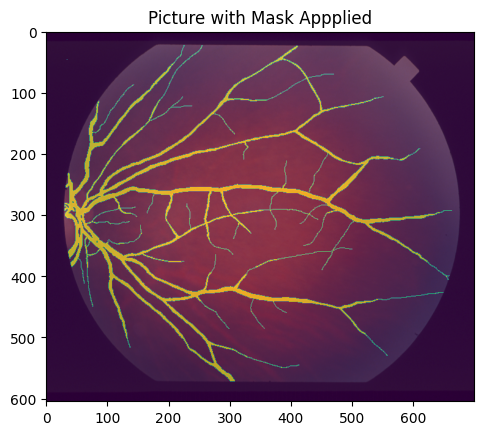

In [9]:
img = Image.open(IMAGE_PATH + df['id'][0] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][0] + '.jpg')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [10]:
# Dataloader class
class ImageDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        # self.transform = transform
        # self.patches = patch
        # self.mean = mean
        # self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = np.array(Image.open(self.img_path + self.X[idx] + '.jpg'))
#         img = img[1168:1176,2628:2636].astype('float32') # crop image for testing purposes
        img = img[300:312,300:312].astype('float32') # crop image for testing purposes
#         img = img[:,:].astype('float32') # crop image for testing purposes

        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.jpg').convert('RGB'))
#         mask = mask[1168:1176,2628:2636].astype('float32') # crop image for testing purposes
        mask = mask[300:312,300:312].astype('float32') # crop image for testing purposes
#         mask = mask[:,:].astype('float32') # crop image for testing purposes



        # img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        # image = np.asarray(image.crop((2628, 1168, 2884, 1424)))
        # img = Image.fromarray(img)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # mask = cv2.imread(self.mask_path + self.X[idx] + '.jpg', cv2.IMREAD_GRAYSCALE)
        # mask = Image.fromarray(mask)
        # mask = torch.from_numpy(mask).long()
            
        return img, mask

    

In [11]:
def pixel_accuracy(output, mask):
    print(f"pixel input mask shape:{mask.shape}")
    print(f"pixel input output shape:{output.shape}")
    with torch.no_grad():
        print(f"softmax results: {F.softmax(output, dim=1).shape}")
        output = torch.argmax(F.softmax(output, dim=1), dim=0)
        print(f"pixel mask shape:{mask.shape}")
        print(f"pixel output shape:{output.shape}")
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
    

In [12]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                print(true_class.shape)
                print(true_label.shape)
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
        

In [13]:
# #datasets
# train_set = ImageDataset(IMAGE_PATH, MASK_PATH, X_train)
# val_set = ImageDataset(IMAGE_PATH, MASK_PATH, X_val)

In [14]:
# #dataloader
# batch_size= 1

# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [15]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
#     torch.cuda.empty_cache()
#     train_losses = []
#     test_losses = []
#     val_iou = []
#     val_acc = []
#     train_iou = []
#     train_acc = []
#     # lrs = []
#     min_loss = np.inf
#     decrease = 1 
#     not_improve=0

#     model
#     fit_time = time.time()
#     for e in range(epochs):
#         since = time.time()
#         running_loss = 0
#         iou_score = 0
#         accuracy = 0
#         #training loop
#         model.train()
#         for i, data in enumerate(tqdm(train_loader)):
#             #training phase
#             image, mask = data
#             # print(image.shape)
#             # if patch:
#             #     bs, n_tiles, c, h, w = image.size()

#                 # image = image.view(-1,c, h, w)
#                 # mask = mask.view(-1, h, w)
        
#             image = image
#             mask = mask
#             #forward
#             output = model(image)
#             output_tensor = output.clone().detach()
# #             
#             output_tensor = torch.squeeze(output_tensor,0)
#             print(f"output_save shape is : {output_tensor.shape}")
#             print(f"saving output{i}...")
#             output_img = Image.fromarray(output_tensor.numpy(),"RGB")
#             output_img.save(f"epoch{e}_model_pred{i}.png")
# #             save_image(output_save,f"model_pred{i}.png")

#             loss = criterion(output.to(device), mask.to(device))
#             #evaluation metrics
 
#             accuracy += pixel_accuracy(output, mask)
#             print(f"accuracy: {accuracy}")
#             #backward
#             loss.backward()
#             optimizer.step() #update weight          
#             optimizer.zero_grad() #reset gradient
            
#             #step the learning rate
#             # lrs.append(get_lr(optimizer))
#             scheduler.step() 
            
#             running_loss += loss.item()
#             torch.save({
#                 "epoch":e,
#                 "model_state_dict":model.state_dict(),
#                 "optimizer_state_dict":optimizer.state_dict(),
#                 "loss":loss
#             },f"model_epoch{e}.pt")
#         else:
#             print("Evaluating...")
#             model.eval()
#             test_loss = 0
#             test_accuracy = 0
#             val_iou_score = 0
#             #validation loop
#             with torch.no_grad():
#                 for i, data in enumerate(tqdm(val_loader)):
#                     #reshape to 9 patches from single image, delete batch size
#                     image, mask = data

#                     # if patch:
#                     #     bs, n_tiles, c, h, w = image.size()

#                     #     image = image.view(-1,c, h, w)
#                     #     mask = mask.view(-1, h, w)
                    
#                     image = image
#                     mask = mask
#                     output = model(image)
#                     
#                     #evaluation metrics
#                     # val_iou_score +=  mIoU(output, mask)
#                     print(f"test accuracy output shape:{output.shape}")
#                     print(f"test accuracy mask shape:{mask.shape}")
#                     test_accuracy += pixel_accuracy(output, mask)
#                     #loss
#                     loss = criterion(output, mask)                                  
#                     test_loss += loss.item()
            
#             #calculatio mean for each batch
#             train_losses.append(running_loss/len(train_loader))
#             test_losses.append(test_loss/len(val_loader))


#             if min_loss > (test_loss/len(val_loader)):
#                 print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
#                 min_loss = (test_loss/len(val_loader))
#                 decrease += 1
#                 if decrease % 5 == 0:
#                     print('saving model...')
#                     # torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

#             if (test_loss/len(val_loader)) > min_loss:
#                 not_improve += 1
#                 min_loss = (test_loss/len(val_loader))
#                 print(f'Loss Not Decrease for {not_improve} time')
#                 if not_improve == 7:
#                     print('Loss not decrease for 7 times, Stop Training')
#                     break
            
#             train_acc.append(accuracy/len(train_loader))
#             val_acc.append(test_accuracy/ len(val_loader))
#             print("Epoch:{}/{}..".format(e+1, epochs),
#                   "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
#                   "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),

#                   "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
#                   "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
#                   "Time: {:.2f}m".format((time.time()-since)/60))
        
#     history = {'train_loss' : train_losses, 'val_loss': test_losses,
#                'train_acc' :train_acc, 'val_acc':val_acc}
#     print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
#     return history

In [16]:
# max_lr = 1e-3
# epoch = 3
# weight_decay = 1e-4
# criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.AdamW(fedseg.parameters(), lr=max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
#                                             steps_per_epoch=len(train_loader))

# history = fit(epoch, fedseg, train_loader, val_loader, criterion, optimizer, sched)

In [2]:
lazy_train = LazyDataset("data/stare/examples/stare/datasets/partition3/train/")
lazy_test = LazyDataset("data/stare/examples/stare/datasets/partition3/evaluate/")

lazy_train.load_mappings().head()
lazy_test.load_mappings().head()

lazy_train_dataloader = DataLoader(lazy_train, batch_size = 4, collate_fn = lambda x: tuple(x) )
lazy_test_dataloader = DataLoader(lazy_test, batch_size = 4, collate_fn = lambda x: tuple(x) )

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    # lrs = []
    min_loss = np.inf
    decrease = 1 
    not_improve=0

    model
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, batch in enumerate(tqdm(train_loader)):
            for source,mask in batch:
#                img is in the format[C,H,W]
                top_left = PatchCoord(0,0)
                bottom_right = PatchCoord(700,605)
                # bottom_right = PatchCoord(8,4)
                full_img = source.retrieve(top_left,bottom_right,"orig")
                full_mask = mask.retrieve(top_left, bottom_right, "orig")
                img_height = full_img.shape[1]
                print(f"FULL IMAGE HEIGHT {img_height}")
                img_width = full_img.shape[2]
                print(f"FULL IMAGE WIDTH {img_width}")
                
                img_patch_gen = fedseg.generate_patches(image=full_img,image_height=700,image_width=605,patch_height=12,patch_width=12)
                mask_patch_gen = fedseg.generate_patches(image=full_mask,image_height=700,image_width=605,patch_height=12,patch_width=12)
            patch_counter = 0
            trg_gen = zip(img_patch_gen,mask_patch_gen)
            for chw_image,mask in trg_gen:
                
                
            #training phase
#                 chw_image = next(img_patch_gen)
#                 print(f"DAS IMAGE:{chw_image.shape}")
#                 mask = next(mask_patch_gen)
#                 print(f"DAS MASK {type(mask[0])}")

                #forward
                #         input from lazy dataloader is (C,H,W) so we permute to (H,W,C)

                hwc_image = torch.permute(chw_image,(1,2,0))
    #             output is in (B,H,W,C) format, so we have to permute it to match the (C,H,W) format of the mask
                print(f"type of hwc_image passed to model is {type(hwc_image)}")
                output = model(hwc_image)
                print(f"model out shape is {output.shape}")
                chw_output = torch.permute(output,(0,3,1,2))
                print(f"model output shape after permutation is {chw_output.shape}")
                output_tensor = chw_output.clone().detach()
    #             
                output_tensor = torch.squeeze(output_tensor,0)
                print(f"output_save shape is : {output_tensor.shape}")
    #             Exporting/Saving the output
                print(f"saving output{i}...")
                chw_output_block = da.block(output_tensor.numpy())
                patched_img_exporter = PatchedImage()
                exported = patched_img_exporter.export(trained=chw_output_block,dst_filename=f"export_epoch{e}_patch{patch_counter}_pred{i}.png")

                hwc_savearray = torch.squeeze(hwc_image,0)
                output_img = Image.fromarray(hwc_savearray.numpy(),"RGB")

                output_img.save(f"PIL_epoch{e}_patch{patch_counter}_pred{i}.png")
                hwc_output_block = da.block(hwc_savearray.numpy())
                patched_img_exporter = PatchedImage()
                exported = patched_img_exporter.export(trained=hwc_output_block,dst_filename=f"exportHWC_epoch{e}_patch{patch_counter}_pred{i}.png")
    #             save_image(output_save,f"model_pred{i}.png")
                print(f"shape of mask being passed to critetrion is {mask.shape}")
                print(f"type of output is {chw_output.type()}")
                print(f"type of mask is {mask.type()}")
    #             because the mask is of type torach.ByteTensor, we have to cast it to float
                mask_long = mask.long()
                loss = criterion(chw_output.to(device), mask_long.to(device))
                #evaluation metrics

                accuracy += pixel_accuracy(chw_output, mask)
                print(f"accuracy: {accuracy}")
                #backward
                loss.backward()
                optimizer.step() #update weight          
                optimizer.zero_grad() #reset gradient

                #step the learning rate
                # lrs.append(get_lr(optimizer))
                scheduler.step()
                patch_counter += 1

                running_loss += loss.item()
                torch.save({
                    "epoch":e,
                    "model_state_dict":model.state_dict(),
                    "optimizer_state_dict":optimizer.state_dict(),
                    "loss":loss
                },f"model_epoch{e}.pt")
            
        else:
            print("Evaluating...")
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, batch in enumerate(tqdm(val_loader)):
                    for source,mask in batch:
        #                 img is in the format[C,H,W]
                        top_left = PatchCoord(0,0)
                        bottom_right = PatchCoord(700,605)
                        full_img = source.retrieve(top_left,bottom_right,"orig")
                        full_mask = mask.retrieve(top_left, bottom_right, "orig")
                        img_height = full_img.shape[1]
                        print(f"FULL IMAGE HEIGHT {img_height}")
                        img_width = full_img.shape[2]
                        print(f"FULL IMAGE WIDTH {img_width}")

                        img_patch_gen = fedseg.generate_patches(image=full_img,image_height=700,image_width=605,patch_height=12,patch_width=12)
                        mask_patch_gen = fedseg.generate_patches(image=full_mask,image_height=700,image_width=605,patch_height=12,patch_width=12)

                    #training phase
                    chw_image = next(img_patch_gen)                    
                    mask = next(mask_patch_gen)
                    

                    #forward
                    #         input from lazy dataloader is (C,H,W) so we permute to (H,W,C)

                    hwc_image = torch.permute(chw_image,(1,2,0))
        #             output is in (B,H,W,C) format, so we have to permute it to match the (C,H,W) format of the mask
                    print(f"type of hwc_image passed to model is {type(hwc_image)}")
                    output = model(hwc_image)
                    print(f"model out shape is {output.shape}")
                    chw_output = torch.permute(output,(0,3,1,2))
                    print(f"model output shape after permutation is {chw_output.shape}")
                    output_tensor = chw_output.clone().detach()
        #             
                    output_tensor = torch.squeeze(output_tensor,0)
                    print(f"output_save shape is : {output_tensor.shape}")
                    print(f"saving output{i}...")
                    output_img = Image.fromarray(output_tensor.numpy(),"RGB")
                    output_img.save(f"epoch{e}_model_eval{i}.png")
                    print(f"shape of mask being passed to critetrion is {mask.shape}")
                    print(f"type of output is {chw_output.type()}")
                    print(f"type of mask is {mask.type()}")
        #             because the mask is of type torch.ByteTensor, we have to cast it to long as crossentropy requires a longtensor for the ta
                    mask_long = mask.long()
            
            
                    #evaluation metrics
                    # val_iou_score +=  mIoU(output, mask)
                    print(f"test accuracy output shape:{output.shape}")
                    print(f"test accuracy mask shape:{mask.shape}")
                    test_accuracy += pixel_accuracy(chw_output, mask_long)
                    #loss
                    loss = criterion(chw_output, mask_long)                                  
                    test_loss += loss.item()
            
            #calculate mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),

                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_acc' :train_acc, 'val_acc':val_acc}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [19]:
max_lr = 1e-3
epoch = 3
weight_decay = 1e-4
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(fedseg.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(lazy_train_dataloader))

history = fit(epoch, fedseg, lazy_train_dataloader, lazy_test_dataloader, criterion, optimizer, sched)

  0%|          | 0/1 [00:00<?, ?it/s]

ZeroDivisionError: division by zero

TODO - Kenneth

0. Checking through forward func to fix RuntimeError: The size of tensor a (2) must match the size of tensor b (8) at non-singleton dimension 1
1. DA block output
2. Try increase patch size to 32 x 32
21246

TODO - Fel

0. generator chain
1. dask to parallelise processing
2. convert to .py file